# Scurblets 
Reference: [Benchmarking Computational Doublet-Detection Methods for Single-Cell RNA Sequencing Data](https://www.sciencedirect.com/science/article/pii/S2405471220304592?ref=pdf_download&fr=RR-2&rr=9011648aec11437b) (Xi and Li, 2021)

GitHub Sourcecode: [code link](https://github.com/AllonKleinLab/scrublet/blob/master/examples/scrublet_basics.ipynb)

The first part is what I tried by looking up the source code (20250112). The second part is the source code.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import matplotlib.pyplot as plt
import scrublet as scr
from matplotlib import rcParams
%matplotlib inline
import scipy.sparse
import sys 
import os
sys.path.append(os.path.abspath('/Users/rusher/Desktop/BIO446/projects/project 2/sc_module.py'))
import sc_module as sm

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi = 80)

# *** Input File ***  h5 file  
sample_name = r'sc92'
h5_file_path = r'./results/'

# integration = 'combat'
# integration = 'harmony'
integration = 'scanorama'
if integration == 'combat':
    h5_file = h5_file_path + sample_name + '_combat_corrected_scran.h5ad'
elif integration == 'harmony':
    h5_file = h5_file_path + sample_name + '_harmony_corrected_scran.h5ad'
elif integration == 'scanorama':
    h5_file = h5_file_path + sample_name + '_scanorama_corrected_scran.h5ad'


# use if batch correction is in question or single sample
# h5_file = h5_file_path + sample_name + '_lognorm_scran.h5ad'   
lognorm = True  # set true if using lognorm data
lognorm = False

# filtered data to be updated with cluster information
filtered_file = h5_file_path + sample_name + '_filt.h5ad'

# Path to output data
results_file_path = r'results/'
clustered_file = results_file_path + sample_name + r'_clustered.h5ad'
clustered_filtered_file = results_file_path + sample_name + r'_filt_clustered.h5ad'  # the file that will store the raw counts plus cluster data


scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [2]:
# Load the h5ad file
adata = sc.read_h5ad(h5_file)
adata.uns['log1p']["base"] = None    # bug fix

# adata.obs_names_make_unique()
print(adata.obs['sample'].value_counts())
print()
print(adata)
print()
print('X matrix is sparse:', scipy.sparse.issparse(adata.X))
print('X size =', adata.X.shape)

sample
60day3    12058
60day1    10254
60day2     9609
Name: count, dtype: int64

AnnData object with n_obs × n_vars = 31921 × 24178
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts', 'type', 'sample', 'batch_type', 'batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_

In [3]:
# Load the raw counts matrix from the sc92 file
counts_matrix = adata.raw.X if adata.raw else adata.X
#print(counts_matrix)

# Ensure the counts matrix is in the correct format (scipy sparse matrix)
if not scipy.sparse.issparse(counts_matrix):
    counts_matrix = scipy.sparse.csc_matrix(counts_matrix)

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))

Counts matrix shape: 31921 rows, 24178 columns


### Initialize scrublet object

`expected_doublet_rate`=0.06
	•	This parameter tells Scrublet the expected proportion of doublets in the dataset. In this case, 6% of the cells are expected to be doublets.
	•	The default value is usually dataset-specific, as the doublet rate depends on factors like the sequencing platform, the number of cells captured, and the total volume of the library.
	•	For droplet-based methods (e.g., 10x Genomics), 5-10% is common.
	•	For plate-based methods, the rate may be lower.

In [4]:
# Initialize Scrublet object 
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

#### Run the default pipeline, which includes:
1. Doublet simulation
2. Normalization, gene filtering, rescaling, PCA
3. Doublet score calculation 
4. Doublet score threshold detection and doublet calling


In [5]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(
    min_counts=2, #Filters out genes with fewer than 2 counts across all cells.
    min_cells=3,  #Filters out cells with fewer than 3 genes.
    min_gene_variability_pctl=85, #Keeps the top 85th percentile of genes based on variability.
    n_prin_comps=30 #The number of Principal Components (PCs) to use for dimensionality reduction.
)

Preprocessing...


/opt/anaconda3/lib/python3.12/site-packages/scrublet/helper_functions.py:251: RuntimeWarning: invalid value encountered in sqrt
  CV_eff = np.sqrt((1+a)*(1+b) - 1);
/opt/anaconda3/lib/python3.12/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 68.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.4%
Elapsed time: 82.1 seconds


#### Plot doublet score histograms

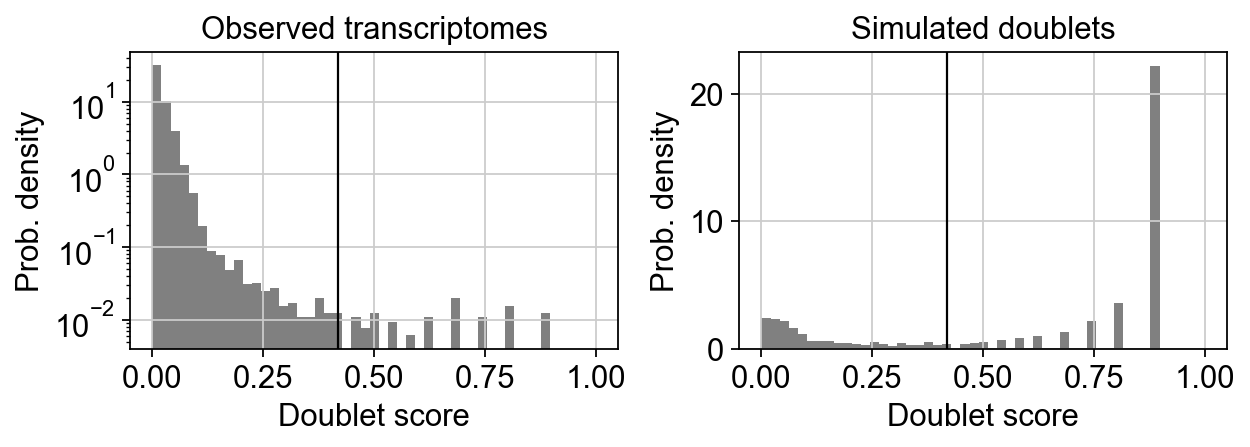

In [6]:
scrub.plot_histogram(); #Default threshold??

1. Clear Separation Between Singlets and Doublets:
	•	In the observed transcriptomes (left panel), most cells have low doublet scores, but there is a distinct “tail” or secondary peak for cells with higher scores.
	•	The presence of a high peak in the simulated doublets (right panel) shows that Scrublet successfully identifies patterns characteristic of doublets.

2.	Threshold Selection:
	•   Cells with scores above this threshold are flagged as doublets.
    
3.	Data Quality:
	•	The clear peaks and separation between observed and simulated doublets suggest good data quality and effective doublet detection.
	•	If the peaks were less distinct, it could indicate technical noise, insufficient variability in the dataset, or parameter settings needing adjustment.

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

## Scrublet Reference code from GitHub

In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

#### Download 8k PBMC data set from 10X Genomics
Download raw data from this link:
http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz


Or use wget:

In [3]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

--2018-10-04 11:21:04--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.35.78.24, 13.35.78.116, 13.35.78.82, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.35.78.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  16.5MB/s    in 2.2s    

2018-10-04 11:21:07 (16.5 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



Uncompress:

In [4]:
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz

#### Load counts matrix and gene list
Load the raw counts matrix as a scipy sparse matrix with cells as rows and genes as columns.

In [5]:
input_dir = 'filtered_gene_bc_matrices/GRCh38/'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 8381 rows, 33694 columns
Number of genes in gene list: 33694


#### Initialize Scrublet object
The relevant parameters are:
- *expected_doublet_rate*: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter. For this example, the expected doublet rate comes from the Chromium User Guide: https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC
- *sim_doublet_ratio*: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
- *n_neighbors*: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value of `round(0.5*sqrt(n_cells))` generally works well.


In [6]:
# Initialize Scrublet object 
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

#### Run the default pipeline, which includes:
1. Doublet simulation
2. Normalization, gene filtering, rescaling, PCA
3. Doublet score calculation 
4. Doublet score threshold detection and doublet calling


In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 61.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.0%
Elapsed time: 11.2 seconds


#### Plot doublet score histograms  for observed transcriptomes and simulated doublets
The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.  
  
To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. `scrub_doublets()` attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the `call_doublets()` function. For example:
```python
scrub.call_doublets(threshold=0.25)
```

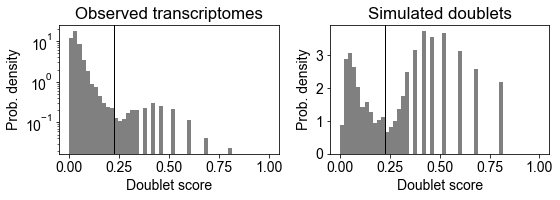

In [8]:
scrub.plot_histogram();

#### Get 2-D embedding to visualize the results

In [9]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

# # Uncomment to run tSNE - slow
# print('Running tSNE...')
# scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))

# # Uncomment to run force layout - slow
# print('Running ForceAtlas2...')
# scrub.set_embedding('FA', scr.get_force_layout(scrub.manifold_obs_, n_neighbors=5. n_iter=1000))
    
print('Done.')

Running UMAP...
Done.


#### Plot doublet predictions on 2-D embedding
Predicted doublets should co-localize in distinct states.

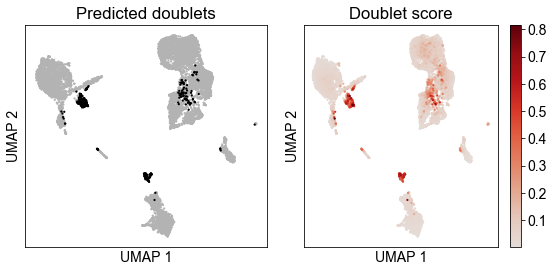

In [10]:
scrub.plot_embedding('UMAP', order_points=True);

# scrub.plot_embedding('tSNE', order_points=True);
# scrub.plot_embedding('FA', order_points=True);